# Load libraries and set device up

In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import seaborn           as sns
import os
import torch
import wandb
import json

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [3]:
n_epochs      = 200
batch_size    = 128
learning_rate = 0.001
dropout       = 0.1
patience      = 10
delta         = 2
train_ratio   = 0.8
test_ratio    = 0.1  # val_ratio = 1 - train_ratio - test_ratio

dpi = 50

target = 'Fv-accurate-fulldata'

input_folder  = 'models'
target_folder = f'{input_folder}/{target}'
model_name    = f'{target_folder}/model.pt'

# Generate or load graph database for training

In [4]:
labels_name                 = f'{target_folder}/labels.pt'
dataset_name                = f'{target_folder}/dataset.pt'
dataset_name_std            = f'{target_folder}/standardized_dataset.pt'
labels_name_std             = f'{target_folder}/standardized_labels.pt'
dataset_parameters_name_std = f'{target_folder}/standardized_parameters.json'  # Parameters for rescaling the predictions

if os.path.exists(dataset_name_std) and os.path.exists(dataset_parameters_name_std) and os.path.exists(labels_name_std):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset = torch.load(dataset_name_std)
    labels  = torch.load(labels_name_std)
    
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)

    # Convert NumPy arrays back to PyTorch tensors
    # Load the data from the JSON file
    with open(dataset_parameters_name_std, 'r') as json_file:
        numpy_dict = json.load(json_file)
    
    # Convert torch tensors to numpy arrays
    dataset_parameters = {}
    for key, value in numpy_dict.items():
        try:
            dataset_parameters[key] = torch.tensor(value)
        except:
            dataset_parameters[key] = value

elif os.path.exists(dataset_name) and os.path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, labels, dataset_parameters = standardize_dataset(dataset, labels,
                                                              transformation='inverse-quadratic')
    
    # Save standardized dataset
    torch.save(dataset, dataset_name_std)
    torch.save(labels,  labels_name_std)
    
    # Convert torch tensors to numpy arrays
    numpy_dict = {}
    for key, value in dataset_parameters.items():
        try:
            numpy_dict[key] = value.cpu().numpy().tolist()
        except:
            numpy_dict[key] = value
    
    # Dump the dictionary with numpy arrays to a JSON file
    with open(dataset_parameters_name_std, 'w') as json_file:
        json.dump(numpy_dict, json_file)

else:
    # Generate data
    

# Defining target factor
target_factor = dataset_parameters['target_std'] / dataset_parameters['scale']

/tmp/ipykernel_3190099/2994038758.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(dataset_name_std)
/tmp/ipykernel_3190099/2994038758.py:10: FutureW

Split dataset

In [5]:
# Define the sizes of the train and test sets
# Corresponds to the size wrt the number of unique materials in the dataset
train_size = int(train_ratio * len(dataset))
test_size  = int(test_ratio  * len(dataset))

np.random.shuffle(dataset)

# Random, fast splitting
train_dataset = dataset[:train_size]
val_dataset   = dataset[train_size:-test_size]
test_dataset  = dataset[-test_size:]

del dataset  # Free up CUDA memory

print(f'Number of training   graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of testing    graphs: {len(test_dataset)}')

Number of training   graphs: 58729
Number of validation graphs: 7348
Number of testing    graphs: 7337


Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features

del train_dataset, val_dataset, test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [7]:
model = MPL.GCNN(features_channels=n_node_features,
                 pdropout=dropout)

# Moving model to device
model = model.to(device)

if os.path.exists(f'{target_folder}/model.pt'):
    model.load_state_dict(torch.load(f'{target_folder}/model.pt'))
    model.eval()
model

GCNN(
  (conv1): GraphConv(5, 512)
  (conv2): GraphConv(512, 512)
  (linconv1): Linear(in_features=512, out_features=64, bias=True)
  (linconv2): Linear(in_features=64, out_features=16, bias=True)
  (lin): Linear(in_features=16, out_features=1, bias=True)
)


/tmp/ipykernel_3190099/2086701148.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{target_folder}/model.pt'))


# Train

Define training optimized and criterion 

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = EarlyStopping(patience=patience, delta=delta, model_name=model_name)

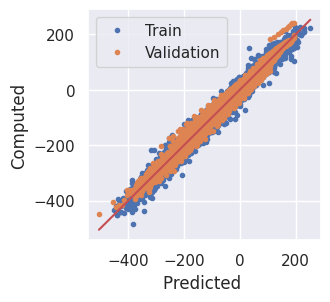

Epoch: 1, Train MAE: 11.2314, Val MAE: 13.9225
Epoch: 2, Train MAE: 11.5090, Val MAE: 12.7310
Epoch: 3, Train MAE: 10.5064, Val MAE: 13.0078
Epoch: 4, Train MAE: 10.4638, Val MAE: 12.8265
Epoch: 5, Train MAE: 10.0424, Val MAE: 12.9594


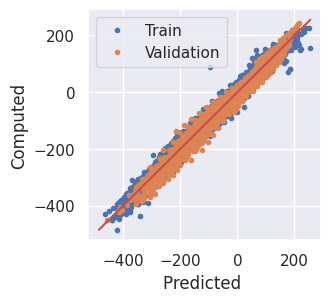

Epoch: 6, Train MAE: 10.2749, Val MAE: 13.3260
Epoch: 7, Train MAE: 9.7365, Val MAE: 11.7410
Epoch: 8, Train MAE: 9.5270, Val MAE: 13.2211
Epoch: 9, Train MAE: 9.4578, Val MAE: 12.5432
Epoch: 10, Train MAE: 9.1424, Val MAE: 11.6174


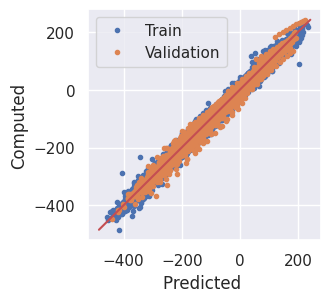

Epoch: 11, Train MAE: 9.1008, Val MAE: 11.7863
Epoch: 12, Train MAE: 8.9756, Val MAE: 12.3069
Epoch: 13, Train MAE: 8.8180, Val MAE: 12.3085
Epoch: 14, Train MAE: 8.6213, Val MAE: 12.6595
Epoch: 15, Train MAE: 8.6561, Val MAE: 12.4244


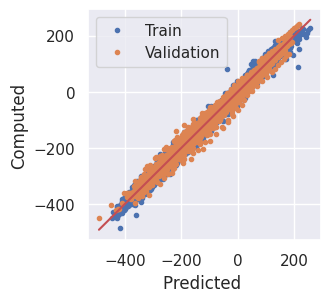

Epoch: 16, Train MAE: 8.4840, Val MAE: 12.0613


In [10]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = MPL.train(model, criterion, train_loader,
                                                                   target_factor.to(device),
                                                                   dataset_parameters['target_mean'].to(device),
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  MPL.test(model, criterion, val_loader,
                                                                   target_factor.to(device),
                                                                   dataset_parameters['target_mean'].to(device))

    # Pass to energy units (same as initial Fv)
    train_loss = np.sqrt(train_loss) * target_factor.item()
    val_loss   = np.sqrt(val_loss)   * target_factor.item()

    if epoch%5 == 0:
        stack = np.concatenate([train_predictions, train_ground_truths,
                                val_predictions,   val_ground_truths])
    
        _min_ = np.min(stack)
        _max_ = np.max(stack)
    
        plt.figure(figsize=(3, 3))
        plt.plot(train_predictions, train_ground_truths, '.', label='Train')
        plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
        plt.xlabel(r'Predicted ')
        plt.ylabel(r'Computed')
        plt.plot([_min_, _max_], [_min_, _max_], '-r')
        plt.legend(loc='best')
        plt.show()
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

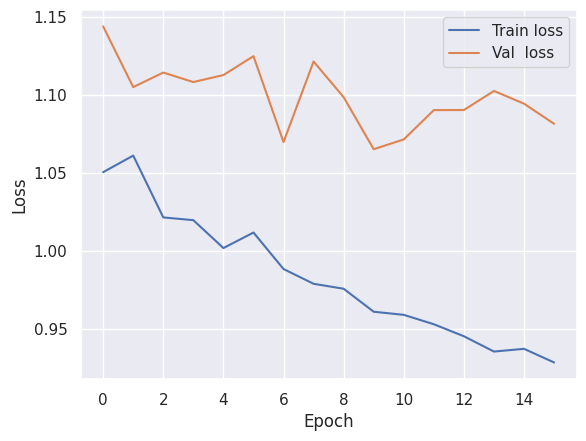

In [11]:
plt.plot(np.log10(train_losses), label='Train loss')
plt.plot(np.log10(val_losses) , label='Val  loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

# Check test data

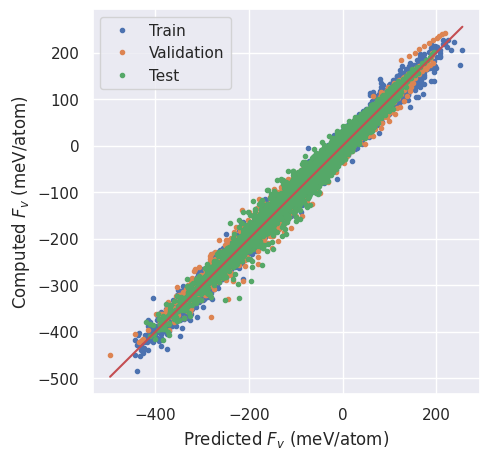

Train MAE: 8.4219, Val MAE: 11.4169, Test MAE: 12.3518


In [13]:
train_loss, train_predictions, train_ground_truths = MPL.train(model, criterion, train_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device),
                                                               optimizer)
val_loss,   val_predictions,   val_ground_truths   =  MPL.test(model, criterion, val_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device),
                                                               )
test_loss,  test_predictions,  test_ground_truths  =  MPL.test(model, criterion, test_loader,
                                                               target_factor.to(device),
                                                               dataset_parameters['target_mean'].to(device),
                                                               )

# Pass to energy units (same as initial Fv)
train_loss = np.sqrt(train_loss) * target_factor.item()
val_loss   = np.sqrt(val_loss)   * target_factor.item()
test_loss  = np.sqrt(test_loss)  * target_factor.item()

stack = np.concatenate([train_predictions, train_ground_truths,
                        val_predictions,   val_ground_truths,
                        test_predictions,  test_ground_truths])

_min_ = np.min(stack)
_max_ = np.max(stack)

plt.figure(figsize=(5, 5))
plt.plot(train_predictions, train_ground_truths, '.', label='Train')
plt.plot(val_predictions,   val_ground_truths,   '.', label='Validation')
plt.plot(test_predictions,  test_ground_truths,  '.', label='Test')
plt.xlabel(r'Predicted $F_v$ (meV/atom)')
plt.ylabel(r'Computed $F_v$ (meV/atom)')
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.legend(loc='best')
plt.savefig(f'{target_folder}/GCNN-training.pdf', dpi=dpi, bbox_inches='tight')
plt.show()

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')